<a href="https://colab.research.google.com/github/NinaAbeyratne/domain-shift-medical-segmentation/blob/main/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import pickle
from scipy.ndimage import gaussian_filter
from skimage import draw
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)

### Mount Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Base directory in Google Drive
BASE_DIR = Path('/content/drive/MyDrive/MV CW')

# Create directories
(BASE_DIR / 'data/synthetic').mkdir(parents=True, exist_ok=True)
(BASE_DIR / 'data/real').mkdir(parents=True, exist_ok=True)
(BASE_DIR / 'data/processed').mkdir(parents=True, exist_ok=True)

print(f"Environment setup complete at: {BASE_DIR}")

Environment setup complete at: /content/drive/MyDrive/MV CW


# Synthetic Data Generation

In [5]:
def generate_synthetic_lung_mask(img_size=256, seed=None):
    """
    Generate a synthetic lung segmentation mask with simplified anatomy.

    Lungs are approximated as two elliptical regions with:
    - Symmetric positioning
    - Smooth boundaries
    - No pathology

    Args:
        img_size: Output image dimensions (square)
        seed: Random seed for reproducibility

    Returns:
        mask: Binary segmentation mask (0=background, 1=lung)
    """
    if seed is not None:
        np.random.seed(seed)

    mask = np.zeros((img_size, img_size), dtype=np.uint8)

    # Left lung (ellipse)
    center_x_left = img_size // 2 - img_size // 6 + np.random.randint(-10, 10)
    center_y = img_size // 2 + np.random.randint(-15, 15)
    radius_x = img_size // 6 + np.random.randint(-5, 5)
    radius_y = img_size // 4 + np.random.randint(-10, 10)

    rr, cc = draw.ellipse(center_y, center_x_left, radius_y, radius_x, shape=mask.shape)
    mask[rr, cc] = 1

    # Right lung (ellipse)
    center_x_right = img_size // 2 + img_size // 6 + np.random.randint(-10, 10)
    rr, cc = draw.ellipse(center_y, center_x_right, radius_y, radius_x, shape=mask.shape)
    mask[rr, cc] = 1

    # Smooth boundaries (realistic lung edges are not perfectly sharp)
    mask = gaussian_filter(mask.astype(float), sigma=1.5)
    mask = (mask > 0.5).astype(np.uint8)

    return mask

In [6]:
mask_final = generate_synthetic_lung_mask(seed=45)
print(mask_final.shape)

(256, 256)


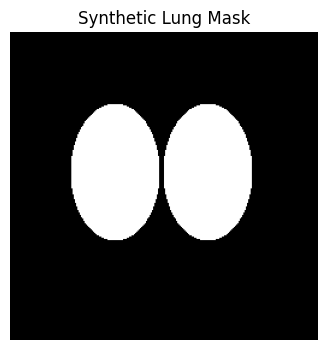

In [7]:
plt.figure(figsize=(4,4))
plt.imshow(mask_final, cmap="gray")
plt.title("Synthetic Lung Mask")
plt.axis("off")
plt.show()

this shows the synthetic lung mask generated and the lungs in white colour.

In [18]:
def generate_synthetic_xray(mask, img_size=256):
    """
    Generate a synthetic chest X-ray from a lung mask.

    Simulates:
    - Lungs: darker (more radiolucent, air-filled)
    - Background: lighter (bone, soft tissue)
    - Minimal noise and artifacts

    Args:
        mask: Binary lung segmentation mask
        img_size: Image dimensions

    Returns:
        image: Synthetic grayscale X-ray image
    """
    # Create base image with uniform background
    image = np.ones((img_size, img_size)) * 0.7  # Background intensity)

    # Lung regions are darker (air is radiolucent)
    image[mask == 1] = 0.25

    # Add subtle gradient to simulate varying Tissue Density
    y_grad = np.linspace(0.95, 1.05, img_size)
    x_grad = np.linspace(0.98, 1.02, img_size)
    gradient = np.outer(y_grad, x_grad)
    image = image * gradient

    # Add minimal Gaussian noise (synthetic data is cleaner)
    noise = np.random.normal(0, 0.02, image.shape)
    image = image + noise

    # Apply slight blur (simulate imaging process)
    image = gaussian_filter(image, sigma=0.8)

    # Normalize to [0, 1]
    image = np.clip(image, 0, 1)

    return image.astype(np.float32)

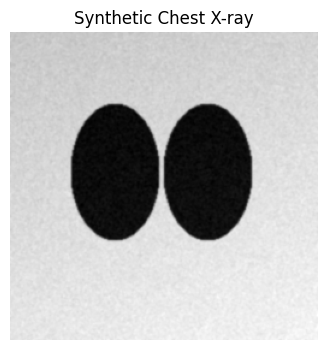

In [19]:
synthetic_xray = generate_synthetic_xray(mask_final)

plt.figure(figsize=(4,4))
plt.imshow(synthetic_xray, cmap="gray")
plt.title("Synthetic Chest X-ray")
plt.axis("off")
plt.show()

this shows the synthetic chest X-ray where the air filled lungs are shown in black because the X-rays are passed through the lungs easily where white colour areas represents dense tissues/bones where X-rays are absorbed.

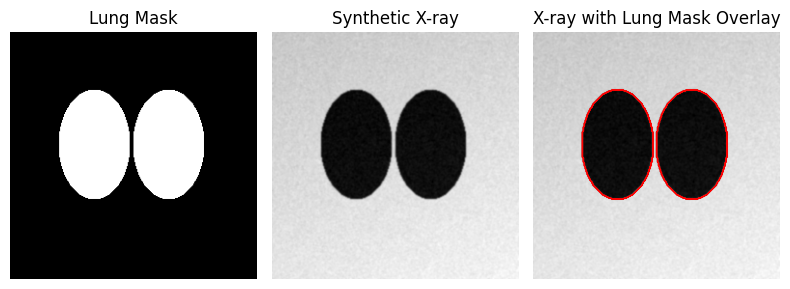

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(8,4))

axs[0].imshow(mask_final, cmap="gray")
axs[0].set_title("Lung Mask")
axs[0].axis("off")

axs[1].imshow(synthetic_xray, cmap="gray")
axs[1].set_title("Synthetic X-ray")
axs[1].axis("off")

axs[2].imshow(synthetic_xray, cmap="gray")
axs[2].contour(mask_final, colors='red', linewidths=0.5)
axs[2].set_title("X-ray with Lung Mask Overlay")
axs[2].axis("off")

plt.tight_layout()
plt.show()

Lungs in black and the mask overlay in red which when overlapping shows as a small red outline.

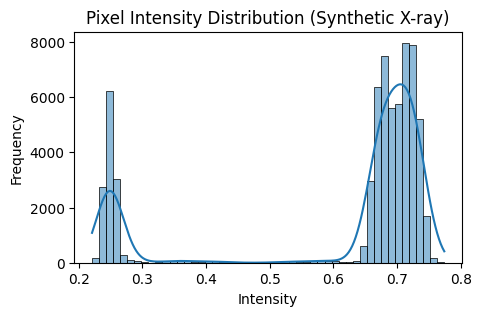

In [21]:
plt.figure(figsize=(5,3))
sns.histplot(synthetic_xray.flatten(), bins=50, kde=True)
plt.title("Pixel Intensity Distribution (Synthetic X-ray)")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.show()

The synthetic X-ray exhibits a realistic bimodal intensity distribution corresponding to lung and non-lung regions

In [26]:
# Generate synthetic dataset
print("\n" + "="*70)
print("GENERATING SYNTHETIC DATASET")
print("="*70)

n_synthetic_train = 800
n_synthetic_val = 100

synthetic_train_images = []
synthetic_train_masks = []
synthetic_val_images = []
synthetic_val_masks = []

print(f"Creating {n_synthetic_train} training samples...")
for i in tqdm(range(n_synthetic_train)):
    mask = generate_synthetic_lung_mask(seed=i)
    image = generate_synthetic_xray(mask)
    synthetic_train_images.append(image)
    synthetic_train_masks.append(mask)

print(f"Creating {n_synthetic_val} validation samples...")
for i in tqdm(range(n_synthetic_val)):
    mask = generate_synthetic_lung_mask(seed=i + 10000)
    image = generate_synthetic_xray(mask)
    synthetic_val_images.append(image)
    synthetic_val_masks.append(mask)

synthetic_train_images = np.array(synthetic_train_images)
synthetic_train_masks = np.array(synthetic_train_masks)
synthetic_val_images = np.array(synthetic_val_images)
synthetic_val_masks = np.array(synthetic_val_masks)

# Add channel dimension at axis=1 (PyTorch format: N,C,H,W)
synthetic_train_images = synthetic_train_images[:, np.newaxis, :, :]
synthetic_val_images   = synthetic_val_images[:, np.newaxis, :, :]

synthetic_train_masks  = synthetic_train_masks[:, np.newaxis, :, :]
synthetic_val_masks    = synthetic_val_masks[:, np.newaxis, :, :]

print(f"\nSynthetic training set: {synthetic_train_images.shape}")
print(f"Synthetic validation set: {synthetic_val_images.shape}")


GENERATING SYNTHETIC DATASET
Creating 800 training samples...


100%|██████████| 800/800 [00:06<00:00, 115.67it/s]


Creating 100 validation samples...


100%|██████████| 100/100 [00:00<00:00, 141.82it/s]



Synthetic training set: (800, 1, 256, 256)
Synthetic validation set: (100, 1, 256, 256)


All images and masks were reshaped to include an explicit channel dimension, conforming to the PyTorch tensor format (N, C, H, W) required for the CNN

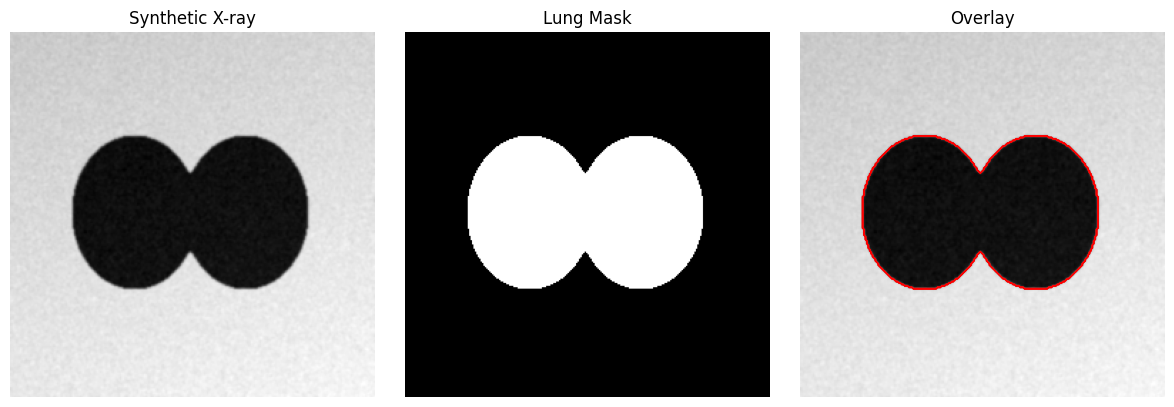

In [28]:
import random

idx = random.randint(0, n_synthetic_train - 1)

fig, axs = plt.subplots(1, 3, figsize=(12,4))

axs[0].imshow(synthetic_train_images[idx, 0], cmap="gray")
axs[0].set_title("Synthetic X-ray")
axs[0].axis("off")

axs[1].imshow(synthetic_train_masks[idx, 0], cmap="gray")
axs[1].set_title("Lung Mask")
axs[1].axis("off")

axs[2].imshow(synthetic_train_images[idx, 0], cmap="gray")
axs[2].contour(synthetic_train_masks[idx, 0], colors='red', linewidths=0.5)
axs[2].set_title("Overlay")
axs[2].axis("off")

plt.tight_layout()
plt.show()

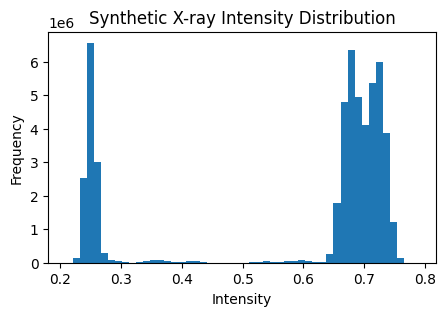

In [29]:
plt.figure(figsize=(5,3))
plt.hist(synthetic_train_images.flatten(), bins=50)
plt.title("Synthetic X-ray Intensity Distribution")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.show()

# Real Data Generation (Simulated From Synthetic)

In [30]:
def generate_real_xray(mask, img_size=256, seed=None):
    """
    Generate a realistic chest X-ray with imaging artifacts and complexity.

    Differences from synthetic:
    - Higher noise levels
    - Contrast variations
    - Texture and structural artifacts
    - Less uniform intensities

    Args:
        mask: Binary lung mask (used as anatomical template)
        img_size: Image dimensions
        seed: Random seed

    Returns:
        image: Simulated real X-ray image
    """
    if seed is not None:
        np.random.seed(seed)

    # Start with base synthetic image
    image = np.ones((img_size, img_size)) * np.random.uniform(0.65, 0.75)

    # Lung regions with more intensity variation
    lung_intensity = np.random.uniform(0.2, 0.35)
    image[mask == 1] = lung_intensity

    # Add anatomical texture (simulates vessels, ribs)
    texture = np.random.randn(img_size, img_size) * 0.05
    texture = gaussian_filter(texture, sigma=2.0)
    image = image + texture

    # Add strong Gaussian noise (real images are noisier)
    noise = np.random.normal(0, 0.05, image.shape)
    image = image + noise

    # Add intensity inhomogeneity (bias field)
    y, x = np.ogrid[:img_size, :img_size]
    bias_field = 1 + 0.15 * np.sin(y / img_size * np.pi) * np.cos(x / img_size * np.pi)
    image = image * bias_field

    # Random contrast adjustment
    contrast_factor = np.random.uniform(0.85, 1.15)
    image = (image - 0.5) * contrast_factor + 0.5

    # Apply stronger blur (simulates motion/patient factors)
    blur_sigma = np.random.uniform(1.0, 2.0)
    image = gaussian_filter(image, sigma=blur_sigma)

    # Normalize
    image = np.clip(image, 0, 1)

    return image.astype(np.float32)

In [31]:
def add_anatomical_complexity_to_mask(mask, seed=None):
    """
    Add realistic irregularities to lung mask boundaries.

    Real lung boundaries are:
    - Not perfectly smooth
    - May have small indentations (vessels, fissures)
    - Can have pathological changes

    Args:
        mask: Binary mask
        seed: Random seed

    Returns:
        mask: Modified mask with irregular boundaries
    """
    if seed is not None:
        np.random.seed(seed)

    # Add small random erosions/dilations
    kernel_size = np.random.choice([3, 5])
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    if np.random.rand() > 0.5:
        mask = cv2.erode(mask, kernel, iterations=1)
    else:
        mask = cv2.dilate(mask, kernel, iterations=1)

    # Add slight noise to boundaries
    boundary_noise = np.random.randn(*mask.shape) * 0.1
    boundary_noise = gaussian_filter(boundary_noise, sigma=2.0)

    mask_float = mask.astype(float) + boundary_noise
    mask = (mask_float > 0.5).astype(np.uint8)

    return mask

In [32]:
# Generate real dataset (simulated)
print("\n" + "="*70)
print("GENERATING REAL DATASET (SIMULATED)")
print("="*70)

n_real_test = 150

real_test_images = []
real_test_masks = []

print(f"Creating {n_real_test} real test samples...")
for i in tqdm(range(n_real_test)):
    # Generate base mask
    base_mask = generate_synthetic_lung_mask(seed=i + 20000)
    # Add anatomical complexity
    mask = add_anatomical_complexity_to_mask(base_mask, seed=i + 20000)
    # Generate realistic image
    image = generate_real_xray(mask, seed=i + 20000)

    real_test_images.append(image)
    real_test_masks.append(mask)

real_test_images = np.array(real_test_images)
real_test_masks = np.array(real_test_masks)

print(f"\nReal test set: {real_test_images.shape}")


GENERATING REAL DATASET (SIMULATED)
Creating 150 real test samples...


100%|██████████| 150/150 [00:02<00:00, 55.96it/s]



Real test set: (150, 256, 256)


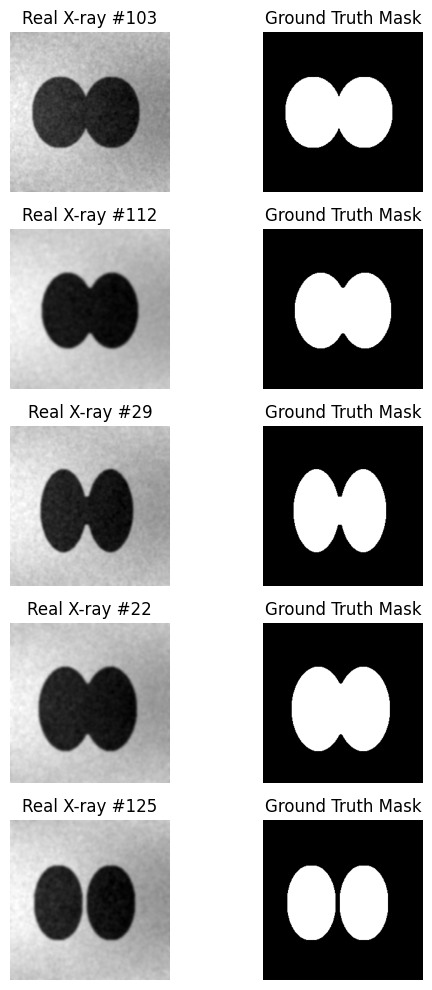

In [33]:
num_samples = 5
indices = random.sample(range(len(real_test_images)), num_samples)

fig, axs = plt.subplots(num_samples, 2, figsize=(6, 2*num_samples))

for i, idx in enumerate(indices):
    axs[i, 0].imshow(real_test_images[idx], cmap='gray')
    axs[i, 0].set_title(f"Real X-ray #{idx}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(real_test_masks[idx], cmap='gray')
    axs[i, 1].set_title("Ground Truth Mask")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

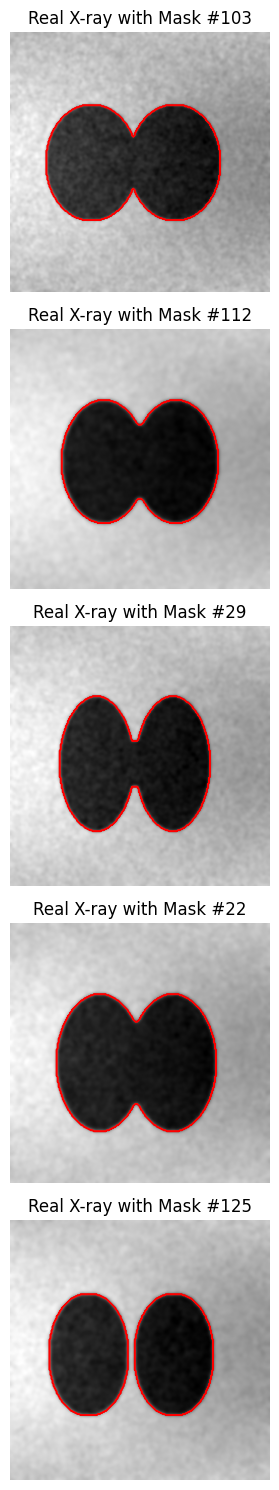

In [36]:
fig, axs = plt.subplots(num_samples, 1, figsize=(4, 3*num_samples))

for i, idx in enumerate(indices):
    axs[i].imshow(real_test_images[idx], cmap='gray')
    axs[i].contour(real_test_masks[idx], colors='red', linewidths=0.6)
    axs[i].set_title(f"Real X-ray with Mask #{idx}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()